In [1]:
import rdkit
import pandas as pd
import torch
from rdkit import Chem
from rdkit.Chem import Draw
from torch.utils.data import Dataset
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np
#IPythonConsole.ipython_useSVG=True\
from captum.attr import *
from torch_geometric.data import Data, DataLoader, Batch
from torch_geometric.utils import accuracy, f1_score
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import TopKPooling, SAGEConv, EdgePooling
from torch_geometric.nn import global_mean_pool as gap, global_max_pool as gmp
from sklearn.model_selection import train_test_split


from visualize import visualize
from Network import Net
from commons import SEEN_ATOMS, atoms, try_catch, gen_graph

RDKit WARNING: [12:23:41] Enabling RDKit 2019.09.3 jupyter extensions


In [2]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

device = 'cpu'

In [3]:
df = pd.read_csv('datasets/solubility_data.csv', header = 0)
df

,Compound ID,ESOL predicted log solubility in mols per litre,Minimum Degree,Molecular Weight,Number of H-Bond Donors,Number of Rings,Number of Rotatable Bonds,Polar Surface Area,measured log solubility in mols per litre,smiles
0,Amigdalin,-0.974,1,457.432,7,3,7,202.32,-0.770,OCC3OC(OCC2OC(OC(C#N)c1ccccc1)C(O)C(O)C2O)C(O)...
1,Fenfuram,-2.885,1,201.225,1,2,2,42.24,-3.300,Cc1occc1C(=O)Nc2ccccc2
2,citral,-2.579,1,152.237,0,0,4,17.07,-2.060,CC(C)=CCCC(C)=CC(=O)
3,Picene,-6.618,2,278.354,0,5,0,0.00,-7.870,c1ccc2c(c1)ccc3c2ccc4c5ccccc5ccc43
4,Thiophene,-2.232,2,84.143,0,1,0,0.00,-1.330,c1ccsc1
...,...,...,...,...,...,...,...,...,...,...
1123,halothane,-2.608,1,197.381,0,0,0,0.00,-1.710,FC(F)(F)C(Cl)Br
1124,Oxamyl,-0.908,1,219.266,1,0,1,71.00,0.106,CNC(=O)ON=C(SC)C(=O)N(C)C
1125,Thiometon,-3.323,1,246.359,0,0,7,18.46,-3.091,CCSCCSP(=S)(OC)OC
1126,2-Methylbutane,-2.245,1,72.151,0,0,1,0.00,-3.180,CCC(C)C


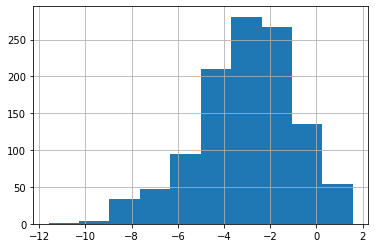

In [4]:
df['measured log solubility in mols per litre'].hist()

In [5]:
#plt.hist(df.pIC50)
#df['act'] = (df.pIC50 > 8.2)*1.0
#df['act'] = (df.logP >= 1) & (df['logP'] <= 4 )
df['logS'] = df['measured log solubility in mols per litre']
df['act'] = df.logS
df['SMILES'] = df.smiles

In [6]:
df.head(5)

,Compound ID,ESOL predicted log solubility in mols per litre,Minimum Degree,Molecular Weight,Number of H-Bond Donors,Number of Rings,Number of Rotatable Bonds,Polar Surface Area,measured log solubility in mols per litre,smiles,logS,act,SMILES
0,Amigdalin,-0.974,1,457.432,7,3,7,202.32,-0.77,OCC3OC(OCC2OC(OC(C#N)c1ccccc1)C(O)C(O)C2O)C(O)...,-0.77,-0.77,OCC3OC(OCC2OC(OC(C#N)c1ccccc1)C(O)C(O)C2O)C(O)...
1,Fenfuram,-2.885,1,201.225,1,2,2,42.24,-3.30,Cc1occc1C(=O)Nc2ccccc2,-3.30,-3.30,Cc1occc1C(=O)Nc2ccccc2
2,citral,-2.579,1,152.237,0,0,4,17.07,-2.06,CC(C)=CCCC(C)=CC(=O),-2.06,-2.06,CC(C)=CCCC(C)=CC(=O)
3,Picene,-6.618,2,278.354,0,5,0,0.00,-7.87,c1ccc2c(c1)ccc3c2ccc4c5ccccc5ccc43,-7.87,-7.87,c1ccc2c(c1)ccc3c2ccc4c5ccccc5ccc43
4,Thiophene,-2.232,2,84.143,0,1,0,0.00,-1.33,c1ccsc1,-1.33,-1.33,c1ccsc1


In [7]:
df['mol'] = df.apply(lambda row: try_catch(Chem.MolFromSmiles, row['SMILES']), axis=1)
df['graph'] = df.apply(lambda row: gen_graph(row['mol'], row['act']), axis=1)

In [8]:
df_train, df_test = train_test_split(df, shuffle=True)
df_train = df
df_test = df

In [9]:
train_data = list(df_train.graph)
train_loader = DataLoader(train_data, batch_size=64, shuffle=True)
test_data = list(df_test.graph)
test_loader = DataLoader(test_data, batch_size=64, shuffle=True)

In [10]:
net = Net(19+len(atoms), device=device)
net = net.to(device)
#loss = nn.BCELoss()
loss = nn.MSELoss()
optimizer = torch.optim.Adam(net.parameters(), lr=2e-3)
EPOCHS = 70

In [14]:
losses = []
print('loss, acc, f1')
for epoch in range(EPOCHS):
    net.train()
    stats = np.zeros(3)
    for data in train_loader:
        data = data.to(device)
        x, edge_index, batch = data.x, data.edge_index, data.batch
        y_pred = net(x, edge_index, batch)
        y = data.y.to(device)
        l = loss(y_pred, y)
        optimizer.zero_grad()
        l.backward()
        optimizer.step()
        stats += data.num_graphs * np.array([l.item(), 0, 0])
#         stats += data.num_graphs * np.array([l.item(),accuracy((y_pred>0.5).int(), y), f1_score((y_pred>0.5).int(), y, 1)])
        #stats += data.num_graphs * np.array([l.item()])#,accuracy((y_pred>0.5).int(), y), f1_score((y_pred>0.5).int(), y, 1)])

    losses.append(stats/len(train_data))
    print('train', losses[-1])
    net.eval()
    stats = np.zeros(3)
    for data in test_loader:
        with torch.no_grad():
            data = data.to(device)
            x, edge_index, batch = data.x, data.edge_index, data.batch
            y_pred = net(x, edge_index, batch)
            y = data.y.to(device)
            l = loss(y_pred, y)
            stats += data.num_graphs * np.array([l.item(), 0, 0])
#             stats += data.num_graphs * np.array([l.item(),accuracy((y_pred>0.5).int(), y), f1_score((y_pred>0.5).int(), y, 1)])
            #stats += data.num_graphs * np.array([l.item()])#,accuracy((y_pred>0.5).int(), y), f1_score((y_pred>0.5).int(), y, 1)])
    losses.append(stats/len(test_data))
    print('test', losses[-1])

loss, acc, f1
train [3.58866279 0.         0.        ]
test [3.33311312 0.         0.        ]
train [3.27290254 0.         0.        ]
test [3.11311339 0.         0.        ]
train [3.20640768 0.         0.        ]
test [3.17839287 0.         0.        ]
train [3.11225966 0.         0.        ]
test [2.84602984 0.         0.        ]
train [2.89891602 0.         0.        ]
test [2.69861663 0.         0.        ]
train [2.75006994 0.         0.        ]
test [3.19210811 0.         0.        ]
train [2.65877277 0.         0.        ]
test [2.42526604 0.         0.        ]
train [2.42276717 0.         0.        ]
test [2.31153073 0.         0.        ]
train [2.46619046 0.         0.        ]
test [2.38621055 0.         0.        ]
train [2.55462441 0.         0.        ]
test [2.27137164 0.         0.        ]
train [2.36535441 0.         0.        ]
test [3.33180993 0.         0.        ]
train [2.27212402 0.         0.        ]
test [2.08401199 0.         0.        ]
train [2.11030

In [15]:
torch.save(net, 'models/gt_model')
#net = torch.load('models/gt_model')

In [12]:
METHODS = {
        "Integrated Gradients": IntegratedGradients,
        "Deep Lift": DeepLift,
        "Gradients": Saliency,
        "Input X Gradients": InputXGradient,
        "Guided Backprop": GuidedBackprop,
    }
#MOLS = ['CC(C)=CCCC(C)=CC(=O)', 'CC(O)=CCCC(C)=CC=O', 'CC(C)=CCCC(C)=CC']
MOLS = ['CCCCC', 'CCCCO']

explainations = {}
for name, method in METHODS.items():
    imgs = visualize(MOLS, net, method, device=device)
    explainations[name] = imgs

/home/alessio/miniconda3/envs/torch/lib/python3.7/site-packages/captum/attr/_utils/gradient.py:33: UserWarning: Input Tensor 0 did not already require gradients, required_grads has been set automatically.
  "required_grads has been set automatically." % index
/home/alessio/miniconda3/envs/torch/lib/python3.7/site-packages/captum/attr/_core/deep_lift.py:301: UserWarning: Setting forward, backward hooks and attributes on non-linear
               activations. The hooks and attributes will be removed
            after the attribution is finished
  after the attribution is finished"""
/home/alessio/miniconda3/envs/torch/lib/python3.7/site-packages/captum/attr/_core/guided_backprop_deconvnet.py:56: UserWarning: Setting backward hooks on ReLU activations.The hooks will be removed after the attribution is finished
  "Setting backward hooks on ReLU activations."


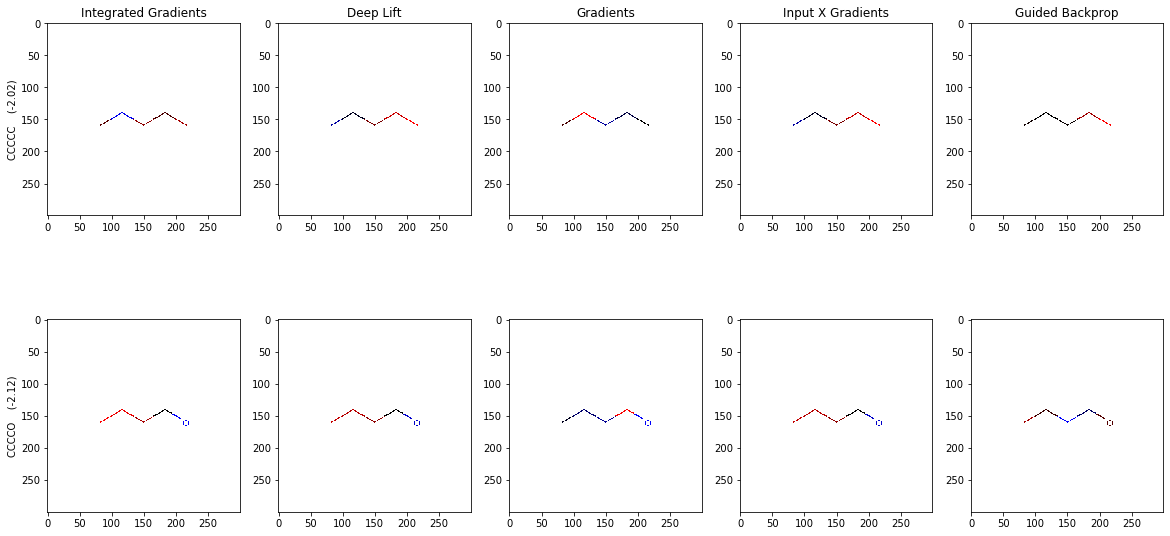

In [13]:
fig, ax = plt.subplots(len(MOLS), len(METHODS), figsize=(10*len(MOLS), 2*len(METHODS)))

for i, (name, imgs) in enumerate(explainations.items()):
    for j, (img, act) in enumerate(imgs):
        ax[j,i].imshow(img)
        ax[j,0].set_ylabel(f"{MOLS[j]}    ({act:.3})")
    ax[0,i].set_title(name)

plt.show()